In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [3]:
drowsy_path = "Driver Drowsiness Dataset (DDD)/Drowsy"
non_drowsy_path = "Driver Drowsiness Dataset (DDD)/Non Drowsy"

def count_images(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif') 
    return sum(1 for filename in os.listdir(directory) if filename.lower().endswith(image_extensions))

# Count images in each directory
drowsy_count = count_images(drowsy_path)
non_drowsy_count = count_images(non_drowsy_path)

print(f"Number of images in Drowsy: {drowsy_count}")
print(f"Number of images in Non Drowsy: {non_drowsy_count}")


Number of images in Drowsy: 22348
Number of images in Non Drowsy: 19445


1. Resizing
2. Greyscale conversion
3. Noise reduction
4. Data augmentation (if needed)
5. Normalization (scaling pixel)
6. Image enhancement (if needed)
7. Feature extraction

In [ ]:
import splitfolders

#Define paths
input_path = "Driver Drowsiness Dataset (DDD)"
output_path = "Dataset_split"

# Split the dataset
splitfolders.ratio(
    input_path,
    output=output_path,
    seed=42,
    ratio=(0.7,0.15,0.15),
    group_prefix=None,
    move=False
)

In [ ]:
import random

test_dir = 'Dataset_split/test'

drowsy_dir = os.path.join(test_dir, 'Drowsy')
non_drowsy_dir = os.path.join(test_dir, 'Non Drowsy')

# Move images from Drowsy directory to test directory
for filename in os.listdir(drowsy_dir):
    src_path = os.path.join(drowsy_dir, filename)
    dst_path = os.path.join(test_dir, f"drowsy_{filename}")
    os.rename(src_path, dst_path)

# Move images from Non Drowsy directory to test directory
for filename in os.listdir(non_drowsy_dir):
    src_path = os.path.join(non_drowsy_dir, filename)
    dst_path = os.path.join(test_dir, f"non_drowsy_{filename}")
    os.rename(src_path, dst_path)

# Remove the now-empty Drowsy and Non Drowsy directories
os.rmdir(drowsy_dir)
os.rmdir(non_drowsy_dir)

print("Images have been combined into the test directory.")

In [ ]:
# Shuffle the images in the test directory
filenames = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]

# Shuffle the filenames
random.shuffle(filenames)

# Rename files to shuffle in place
for index, filename in enumerate(filenames):
    # Define new filename with a sequence number
    new_filename = f"shuffled_{index}_{filename}"
    
    # Define the full path for source and destination
    src_path = os.path.join(test_dir, filename)
    dst_path = os.path.join(test_dir, new_filename)
    
    # Rename the file
    os.rename(src_path, dst_path)

print("Images have been shuffled within the test directory.")

In [ ]:
import shutil
# Define the base test directory and the new subdirectory
base_test_dir = 'Dataset_split/test'
sub_test_dir = os.path.join(base_test_dir, 'all')

# Create the subdirectory if it doesn't exist
os.makedirs(sub_test_dir, exist_ok=True)

# Move all images into the new subdirectory
for filename in os.listdir(base_test_dir):
    if os.path.isfile(os.path.join(base_test_dir, filename)):
        shutil.move(os.path.join(base_test_dir, filename), sub_test_dir)

print("All images have been moved to the 'all' subdirectory.")

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import numpy as np
import cv2
import tensorflow as tf


# Define paths
train_dir = 'Dataset_split/train'
test_dir = 'Dataset_split/test'
val_dir = 'Dataset_split/val'

if not os.path.exists(test_dir):
    print("The test directory does not exist.")
else:
    files = os.listdir(test_dir)
    if not files:
        print("The test directory is empty.")
    else:
        print(f"Found {len(files)} files in the test directory.")
        

# Preprocessing function
def preprocess_function(img):
    # Convert to numpy array for OpenCV
    img_array = img.astype('uint8')
    # Apply Gaussian blur for noise reduction
    img_array = cv2.GaussianBlur(img_array, (5, 5), 0)
    # Normalize the image to 0-1
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array

# Initiate data generators with the custom preprocessing function
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)
val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)

# Create the generators
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    color_mode='grayscale', 
    class_mode='binary'  
)

val_generator = val_data_gen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary'
)

test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    color_mode='grayscale',
    class_mode=None,
    shuffle=True
)


for data_batch, labels_batch in train_generator:
    print("Batch of data shape:", data_batch.shape)
    print("Batch of labels shape:", labels_batch.shape)
    break  

Found 1 files in the test directory.
Found 29254 images belonging to 2 classes.
Found 6271 images belonging to 2 classes.
Found 6268 images belonging to 1 classes.
Batch of data shape: (32, 224, 224, 1)
Batch of labels shape: (32,)


In [27]:
# Check class indices to understand label mapping
print("Training class indices:", train_generator.class_indices)
print("Validation class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Training class indices: {'Drowsy': 0, 'Non Drowsy': 1}
Validation class indices: {'Drowsy': 0, 'Non Drowsy': 1}
Test class indices: {'all': 0}


Batch of data shape: (32, 224, 224, 1)
Batch of labels shape: (32,)


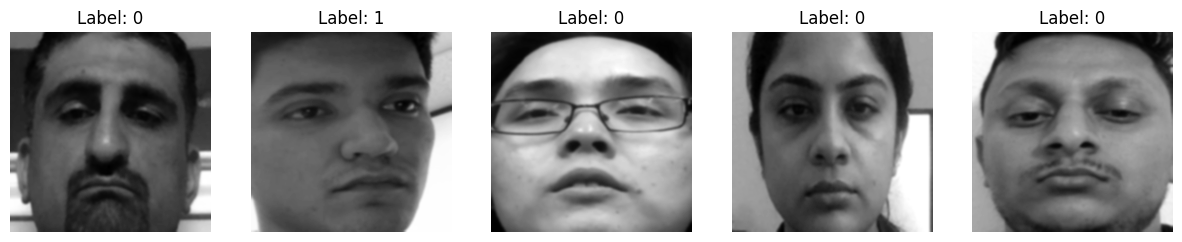

In [20]:
import matplotlib.pyplot as plt

for data_batch, labels_batch in val_generator:
    print("Batch of data shape:", data_batch.shape)
    print("Batch of labels shape:", labels_batch.shape)
    
    # Display a few images from the batch
    num_images_to_display = 5
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images_to_display):
        ax = plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(data_batch[i].squeeze(), cmap='gray')
        plt.title(f"Label: {int(labels_batch[i])}")
        plt.axis("off")
    
    plt.show()
    break

# lable 1 = non drowsy
# label 0 = drowsy

Batch of data shape: (32, 224, 224, 1)


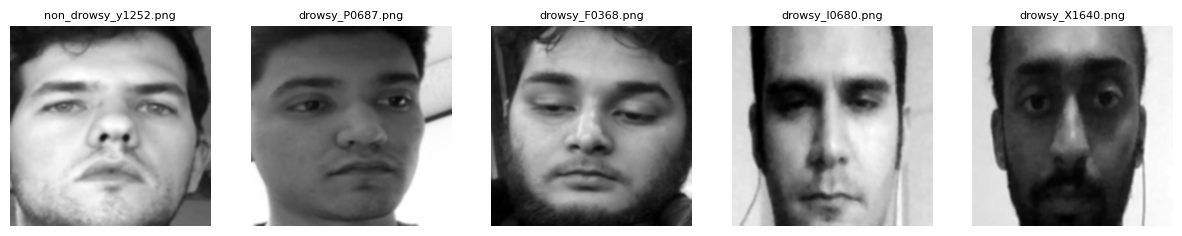

In [30]:
# Display a few sample images from the test generator
for data_batch in test_generator:
    print("Batch of data shape:", data_batch.shape)
    
    num_images_to_display = min(5, data_batch.shape[0])
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images_to_display):
        ax = plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(data_batch[i].squeeze(), cmap='gray')
        image_name = filenames[i].split('/')[-1]  # Extracting image name from path
        plt.title(image_name, fontsize=8)
        plt.axis("off")
    
    plt.show()
    break